#Linear Regression

by Linh Van Nguyen <contact@linhvannguyen.com>

as a part of the demonstration galeries for <a href='http://scikit-learn.org/stable/'>sklearn</a> Machine Learning python package.

------------
This note demonstrates the implementation of Linear Regression to medical data. The problem is based on an example described in the book by Hastie & Tibshirani (2009) pp. 3-4 & 49-63. 
This notebook includes:
- <a href='#part1'>Part 1: Warming up</a>
- <a href='#part2'>Part 2: Regularized Linear Regression and Cross Validation</a>
- <a href='#part3'>Part 3: Subset selection via Rejection test using Z-scores</a>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as lin

##Part 1: Warming up <a id='part1'></a>

** Data description **
Data come from a study published by Stamey et al. (1989). This study aims at the prediction of the level of prostate specific antigen, denoted by lpsa below, from the results of clinical exams. These exams are carried out before a possible prostatectomy.

The measurements are log cancer volume *lcavol* , log prostate weight *lweight* , age of the patient *age* , log of benign prostatic hyperplasia amount *lbph* , seminal vesicle invasion *svi* , log of capsular penetration *lcp* , Gleason score *gleason* , and percent of Gleason scores 4 or 5 *pgg45* . The variables *svi* and *gleason* are categorical, others are quantitative. There are D=8 entries.

**Read & Normalize data**: Data are organized as follows:
* the first column enumerates the data from 1 à 97 (97 male subjects).
* columns 2 to 9 contain the entries themselves.
* column 10 contains target values.
* column 11 contains label 1 for the training set, and 2 for the test set.
    
**Splitting data**: Data are splitted into training and testing set depending on the 10th column (1 for training and 0 for testing sample). Final sets are training data (67 samples) and testing data (30 samples). Each sample has D=8 features.

In [2]:
# Read the data
data_init = np.loadtxt('./data/prostate_data_sansheader.txt')
nrows = np.shape(data_init)[0]
ncols = np.shape(data_init)[1]

data = data_init[:,1:11]   # get rid first column and take from 2nd to 11th columns

# Splitting the database into training and testing one based on the last column indices 
Itrain = np.where(data[:,9]==1);
Itest = np.where(data[:,9]==0)
data_train = np.squeeze(data[Itrain,:])   # training data
data_test = np.squeeze(data[Itest,:])     # testing data

N_tr = np.shape(data_train)[0]
N_test = np.shape(data_test)[0]
D = 8 # dimension of the data
X_train = data_train[:,0:D]
t_train = data_train[:,D]
X_test = data_test[:,0:D]
t_test = data_test[:,D]

** Normalization of the data ** with respect to the mean and standard deviation of the training set

Note:Remember that different regressors or classifiers usually provide the option to fit intercept and normalize the data, but for a better monitor the situation, it is recommended to center and normalize the data always. 

In [3]:
moy = np.zeros(D)
sigma = np.zeros(D)
for k in range(0,D): # D columns of entries
    moy[k] = np.mean(X_train[:,k])
    sigma[k] = np.std(X_train[:,k])
    X_train[:,k] = (X_train[:,k]-moy[k])/sigma[k] # normalized: centered, variance 1
    X_test[:,k] = (X_test[:,k]-moy[k])/sigma[k] # normalized: centered, variance 1

t_mean= np.mean(t_train)
t_sig = np.std(t_train)
t_train_mf = (t_train-t_mean)/t_sig # mean-free target vector of training set

X_train_trans = np.transpose(X_train)

**Autocovariance**: the first step before performing any regression models is to check the correlation between targets and predictors, and also checking the autocorrelation amongs predictors. Strong correlated predictors might suggest a model selection a priori to select the most relevant ones.

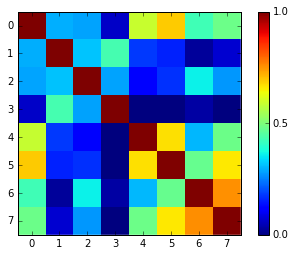

In [4]:
# 1. Autocovariance
autocov = 1.0/N_tr*np.dot(X_train_trans,X_train)
fig=plt.figure()
cax=plt.imshow(autocov, interpolation='none',clim=[0,1],cmap='jet')
fig.colorbar(cax, ticks=[0, 0.5, 1])

[ 0.73315515  0.48521519  0.22764238  0.26293763  0.55688643  0.4892032
  0.34242781  0.44804795]


<Container object of 8 artists>

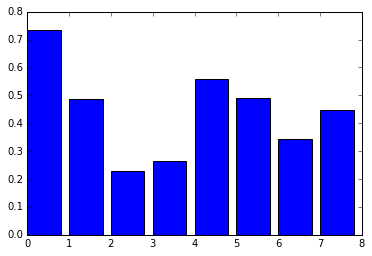

In [5]:
# 2. Correlation
cov = 1.0/N_tr*np.dot(X_train_trans,t_train_mf)
print cov
plt.bar(range(D),cov)

##Part 2: Regularized Linear Regression and Cross Validation <a id='part2'></a>
The main task is from D features ${x^j_n}, i=1,2,...,D$ and $n=1,2,...,N$, $X_n := [x^1_n,x^2_n,...,x^D_n] \in R^D$, one would like to predict target $t_n$ as a function of $X_n$: $X_n \to t_n=f(X_n)$. 

### Linear Regression
Linear Regression is the first and most simple approach, which estimate the target as a linear combination (or weighted average) of corresponding features: 
$$t_n=\beta_0+\sum_{j=1}^{D}{\beta^j x_n^j} = X_nB$$

Coefficients $B$ is learned from the training data by minimizing the sum of mean square errors:

$$\DeclareMathOperator*{\argmin}{arg\,min}    B=\argmin_B \left\{ \frac{1}{2} \left\lVert XB-t \right\rVert ^2_2 \right\}$$

Taking partial derivative of the loss function and set it to zero:

$$\frac{\partial L}{\partial B} = X^T(XB-t) = 0$$

one get

$$B=(X^TX)^{-1}Xt$$

### Ridge Regression (L2-penalty)

RR regularizes the regression by adding a L2-penalty term in the cost function:

$$\DeclareMathOperator*{\argmin}{arg\,min}    B=\argmin_B \left\{ \frac{1}{2} \left\lVert XB-t \right\rVert ^2_2 + \frac{\lambda}{2} \left\lVert B \right\rVert ^2_2 \right\}$$

Similarly, taking the derivative and set to zeros, one gets:

$$B=(X^TX+\lambda I)^{-1}Xt$$

/home/nguyen/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


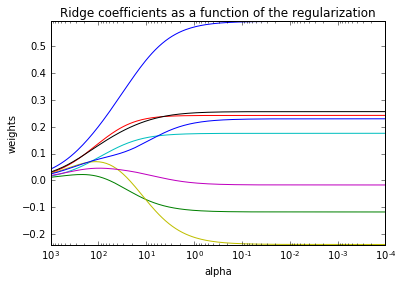

In [6]:
from sklearn import linear_model

n_alphas = 200
alphas = np.append([0],np.logspace(-4, 3, n_alphas-1))
clf = linear_model.Ridge( fit_intercept=False, normalize=False)

coefs = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X_train, t_train_mf)
    coefs.append(clf.coef_)

ax = plt.gca()
ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm', 'b'])

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()


**Cross Validataion** using function *linear_model.RidgeCV*

In [7]:
n_alphas = 50
alphas = np.linspace(1e-10, 40, n_alphas)

clf = linear_model.RidgeCV(alphas = alphas, fit_intercept=False, normalize=False)
clf.fit(X_train, t_train_mf)    

print 'Optimal set of coefficients:', clf.coef_
print 'Optimal regularization parameter:', clf.alpha_

t_pred= t_mean+t_sig*clf.predict(X_test)
error_test = 1.0/(len(t_test))*np.sum(np.square(t_test-t_pred))
print "Testing error:", error_test

Optimal set of coefficients: [ 0.5311861   0.23925603 -0.09984633  0.1700149   0.24220651 -0.16326717
  0.00354566  0.18618568]
Optimal regularization parameter: 3.26530612254
Testing error: 0.499773096379


### Lasso (L1-penalty)

Unlike Ridge Regression, Lasso imposes the regularization on the absolute values of the coefficients B:

$$\DeclareMathOperator*{\argmin}{arg\,min}    B=\argmin_B \left\{ \frac{1}{2} \left\lVert XB-t \right\rVert ^2_2 + \lambda \left\lVert B \right\rVert \right\}$$

Since this cost function is not diferential, iterative scheme is used to find the optimal coefficients B.

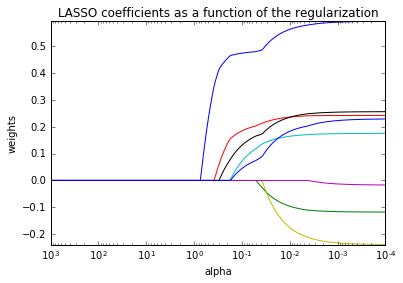

In [8]:
n_alphas = 200
alphas = np.logspace(-4, 3, n_alphas) # should not consider alpha = 0 for LASSO
clf = linear_model.Lasso( fit_intercept=False, normalize=False)

coefs = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X_train, t_train_mf)
    coefs.append(clf.coef_)

ax = plt.gca()
ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm', 'b'])

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('LASSO coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [9]:
n_alphas = 50
alphas = np.logspace(-4, -.5, n_alphas)
lasso_cv = linear_model.LassoCV(alphas=alphas, fit_intercept=False, normalize=False, cv=len(t_train))
lasso_cv.fit(X_train, t_train_mf) 
print 'Optimal set of coefficients:', lasso_cv.coef_
print 'Optimal regularization parameter:', lasso_cv.alpha_

t_pred= t_mean+t_sig*lasso_cv.predict(X_test)
error_test = 1.0/(len(t_test))*np.sum(np.square(t_test-t_pred))
print "Testing error:", error_test

Optimal set of coefficients: [ 0.56698117  0.23732627 -0.09981509  0.16616803  0.23874696 -0.18485191
 -0.          0.18814909]
Optimal regularization parameter: 0.00848342898244
Testing error: 0.498434689757


###How much we can trust this automatical choice of alpha


In [10]:
from sklearn import cross_validation
k_fold = cross_validation.KFold(N_tr, 2,shuffle=True)

lasso_cv = linear_model.LassoCV(fit_intercept=False, normalize=False)
for k, (train, test) in enumerate(k_fold):
    lasso_cv.fit(X_train[train], t_train_mf[train])
    t_pred= t_mean+t_sig*lasso_cv.predict(X_train[test]) # remember that t_train here is mean-free and variance 1, so is t_pred
    error_test = 1.0/(len(t_pred))*np.sum(np.square(t_train[test]-t_pred))
    print("[fold {0}] alpha: {1:.5f}, MSE: {2:.5f}".format(k, lasso_cv.alpha_, error_test))

[fold 0] alpha: 0.17601, MSE: 0.76292
[fold 1] alpha: 0.03758, MSE: 0.83410


##Part 3: Subset selection via Rejection test using Z-scores <a id='part3'></a>
Now we turn to the selection of the most significant entries so that our predictor be more robust. The essential idea is that our estimates will be more robust if only the most significant entries are taken into account. As a consequence, note that we will reduce the dimension of the problem from p=8 to some smaller dimension. The present approach uses a statistical test to decide whether the regression coefficient corresponding to some entry is significantly non-zero. Then we can decide either to put non significant coefficients to zero, or to select the significant entries only and estimate the new reduced regression vector.

Let's assume that target values are noisy due to some white Gaussian noise with variance $\sigma^2$ (see Hastie & Tibshirani p. 47). One can show that the estimated regression vector $\hat{\beta}$ is also Gaussian with variance $$var(\hat{\beta})=\left(X^TX\right)^{-1}\sigma^2$$

One can also show that the estimator of the variance (from the training set) $$\hat{\sigma}^2=\frac{1}{N-D-1}\sum{\left(t_n-\hat{t}_n \right)^2}$$

obeys a Chi-2 distribution. As a consequence a Chi-square statistical test can be used to determine whether some
coefficient $\beta_j$ is significantly non-zero. To this aim, one defines the variables $z_j$ named Z-scores which in turn obey a Fisher law, also called $t$-distribution, which are often used in statistics: $$z_j=\frac{\beta_j}{\hat{\sigma}\sqrt{v_j}}$$ where $v_j$ is the $j$-th diagonal element of the matrix $\left(X^TX\right)^{-1}$.

In [11]:
X_train = data_train[:,0:D]
t_train = data_train[:,D]
X_test = data_test[:,0:D]
t_test = data_test[:,D]

moy = np.zeros(D)
sigma = np.zeros(D)
for k in range(0,D): # D columns of entries
    moy[k] = np.mean(X_train[:,k])
    sigma[k] = np.std(X_train[:,k])
    X_train[:,k] = (X_train[:,k]-moy[k])/sigma[k] # normalized: centered, variance 1
    X_test[:,k] = (X_test[:,k]-moy[k])/sigma[k] # normalized: centered, variance 1

beta_0= np.mean(t_train)
t_train_mf = t_train - beta_0 # mean free target
x,resid,rank,s = np.linalg.lstsq(np.dot(np.transpose(X_train),X_train),np.transpose(X_train))
beta_hat = np.dot(x,t_train_mf)
t_pred = beta_0 + np.dot(X_test,beta_hat)
t_train_pred = beta_0 + np.dot(X_train,beta_hat)

print "Beta: ", beta_hat

Beta:  [ 0.71104059  0.29045029 -0.14148182  0.21041951  0.30730025 -0.28684075
 -0.02075686  0.27526843]


In [12]:
v=np.diag(np.linalg.inv(np.dot(np.transpose(X_train),X_train)))
sig=np.sqrt(sum(np.square(t_train_pred-t_train))/(N_tr-D-1.0))
zscore=beta_hat/(sig*np.sqrt(v))
print zscore

[ 5.36629046  2.75078939 -1.39590898  2.05584563  2.46925518 -1.86691264
 -0.14668121  1.73783972]


For sake of simplicity, we will consider that the null hypothesis of $\beta_j$ is rejected with probability 95% if the Z-score is greater than 2. This is corresponding to a subset selection procedure, and target vectors are now estimated using only some of the entries only. This model gives the smallest error compared to all L2 and L1 penalty as described above.

In [13]:
# Subset selection
X_train_select=np.squeeze(X_train[:,np.where(zscore>2)])
X_test_select=np.squeeze(X_test[:,np.where(zscore>2)])

# Re-train the regression
x,resid,rank,s = np.linalg.lstsq(np.dot(np.transpose(X_train_select),X_train_select),np.transpose(X_train_select))
beta_hat = np.dot(x,t_train_mf)
print beta_hat

# compute error
t_pred = beta_0 + np.dot(X_test_select,beta_hat)
error_test = 1.0/(len(t_test))*np.sum(np.square(t_test-t_pred))
print "Testing error:", error_test

[ 0.62345     0.25488273  0.20339287  0.2800554 ]
Testing error: 0.45633212204
